PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle ¶

hotel_address — hotel address;
review_date — the date when review was posted;
average_score — avarage hotel score;
hotel_name — hotel name;
reviewer_nationality — reviewer's country;
negative_review — negative review given to the hotel by the reviewer;
review_total_negative_word_counts — the amount of words in the negative review;
positive_review — positive review given to the hotel by the reviewer;
review_total_positive_word_counts — the amount of words in the positive review;
reviewer_score — the score given to the hotel by the reviwer who stayed there;
total_number_of_reviews_reviewer_has_given — the number of reviews given by a particular reviewer;
total_number_of_reviews — the total number of reviews given to this hotel;
tags — the tags used by the reviewer in the review;
days_since_review — how many days it's been since the review was left (?);
additional_number_of_scoring — score points reviewers gave to the hotel without writing a review (?);
lat — the hotels' latitude;
lng — the hotel's longtitude.

In [311]:
#importing libraries
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns


import category_encoders as ce

from collections import Counter

from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

#!pip install pycountry
import pycountry

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [312]:
! pip freeze > requirements.txt

In [313]:
df_train = pd.read_csv(r"/kaggle/input/sf-booking/hotels_train.csv")
df_test = pd.read_csv(r"/kaggle/input/sf-booking/hotels_test.csv")

# Adding a column to distinguish between train and test data
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'


In [314]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [315]:
print("Number of duplicates found:", df_test.duplicated().sum())

Number of duplicates found: 29


In [316]:
num_duplicates_train = df_train.duplicated().sum()
print(f"Number of duplicates found in train data: {num_duplicates_train}")
df_train = df_train.drop_duplicates()

Number of duplicates found in train data: 307


In [317]:
# Temporarily joining the dataframes to ensure they have the same features 
#(will separate them later before running the ML algorithm): 
hotels = pd.concat([df_train, df_test], ignore_index=True)

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Other than the target variable, only two features have missing values ('lat' and 'lng'). They are not easy to fill in, so we'll deal with them below. 

For now, we'll delete any duplicates.

Let's see how many unique values each feature has.

In [318]:
hotels.nunique()

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
reviewer_score                                    37
tags                                           55242
days_since_review                                731
lat                                             1472
lng                                             1472
dataset                                            2
dtype: int64

### Transforming the data

The 'hotel_name' feature has a lot of unique values and is unlikely to be informative, so we'll drop it.

In [319]:
hotels = hotels.drop(columns=['hotel_name'])

Let's work on the 'address' feature — we'll extract the country and the city from it.

In [320]:
# Function to extract country from the address
def extract_country(address):
    countries = [country.name for country in pycountry.countries]
    for country in countries:
        if country in address:
            return country
    return None

hotels['country'] = hotels['hotel_address'].apply(extract_country)

# Checking how many unique countries there are in the dataset
hotels['country'].nunique()

6

In [321]:
hotels['country'].unique()

array(['United Kingdom', 'France', 'Netherlands', 'Italy', 'Austria',
       'Spain'], dtype=object)

In [322]:
# Since there is only 6 countries and the foramt of the values in the'address" feature is varied,
# we can try to identify the cities by creating a lost of most popular toursit cities
# in the given countries, matching the list against our df and seeing if there are any missing
#values afterwords

popular_cities = [
    'Vienna', 'Salzburg', 'Innsbruck', 'Graz', 'Linz', # Austria
    'London', 'Edinburgh', 'Manchester', 'Birmingham', 'Glasgow', # UK
    'Paris', 'Marseille', 'Lyon', 'Nice', 'Toulouse', # France
    'Rome', 'Venice', 'Florence', 'Milan', 'Naples', # Italy
    'Barcelona', 'Madrid', 'Seville', 'Valencia', 'Bilbao', # Spain
    'Amsterdam', 'Rotterdam', 'The Hague', 'Utrecht', 'Eindhoven' # Netherlands
]

# Function to extract city from address
def extract_city(address):
    for city in popular_cities:
        if city.lower() in address.lower():
            return city
    return None

# Applying the function to the address column
hotels['city'] = hotels['hotel_address'].apply(extract_city)
hotels['city'].unique()



array(['London', 'Paris', 'Amsterdam', 'Milan', 'Vienna', 'Barcelona'],
      dtype=object)

In [323]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   reviewer_nationality                        515431 non-null  object 
 5   negative_review                             515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   positive_review                             515431 non-null  object 
 9   review_total_positive_word_counts           515431 non-null  int64  
 

Since there is only 6 cities — one city representing each country and no null values, we've identified all the cities in the dataset and can drop the 'country' feature. The cities we will one-hot encode. 

In [324]:
city_dummies = pd.get_dummies(hotels['city'], prefix='city').astype(int)
hotels = pd.concat([hotels, city_dummies], axis=1)

Now that we know the cities, we can fill in the missing 'lat' and 'lng' values with the mean coordinates for each city.

In [325]:
filled_lat = hotels['lat'].copy()
filled_lng = hotels['lng'].copy()

grouped = hotels.groupby('city')

for name, group in grouped:
    lat_mean = group['lat'].mean()
    lng_mean = group['lng'].mean()

    filled_lat[group.index] = group['lat'].fillna(lat_mean)
    filled_lng[group.index] = group['lng'].fillna(lng_mean)

hotels['lat'] = filled_lat
hotels['lng'] = filled_lng

We can also use a dictionary with the coordinates of each city's downtown area to find out whether the hotel is located downtown (a new binary feature).

In [326]:
downtown_info = {
    'London': {'coords': (51.5074, -0.1278), 'radius': 3},
    'Paris': {'coords': (48.8566, 2.3522), 'radius': 2},
    'Amsterdam': {'coords': (52.3676, 4.9041), 'radius': 2},
    'Milan': {'coords': (45.4642, 9.1900), 'radius': 2},
    'Vienna': {'coords': (48.2082, 16.3738), 'radius': 2},
    'Barcelona': {'coords': (41.3851, 2.1734), 'radius': 2}
}

# Haversine formula to calculate the distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon1 - lon2)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

# Function to determine if a hotel is downtown
def is_downtown(row):
    city = row['city']
    lat, lon = row['lat'], row['lng']
    if city in downtown_info:
        city_info = downtown_info[city]
        downtown_coords = city_info['coords']
        radius = city_info['radius']
        distance = haversine(lat, lon, downtown_coords[0], downtown_coords[1])
        return 1 if distance <= radius else 0
    return 0

hotels['is_downtown'] = hotels.apply(is_downtown, axis=1)

hotels['is_downtown'].value_counts()

is_downtown
0    269786
1    245645
Name: count, dtype: int64

'reviewer_nationality' feature has 225 unique values; we can use binary encoder to transform it; 

We can also add a feature to see whether the reviewr's nationality is the same as the hotel's country —— perhaps this could affect the way that people rate hotels.

In [327]:
# Creating a new binary feature to see if the reviewer's nationality is the same as the hotel's country
# Function to check if reviewer nationality is the same as hotel country
def is_same_nationality(row):
    return 1 if row['reviewer_nationality'].strip().lower() == row['country'].strip().lower() else 0

# Applying the function to create the new feature
hotels['is_same_nationality'] = hotels.apply(is_same_nationality, axis=1)

print(hotels['is_same_nationality'].value_counts())

is_same_nationality
0    337047
1    178384
Name: count, dtype: int64


In [328]:
# Applying binary encoder to the feature
encoder = ce.BinaryEncoder(cols=['reviewer_nationality'], drop_invariant=True)
hotels = encoder.fit_transform(hotels)

The 'review_date' feature is currently in the 'object' format. We'll transform it into datetime and will extract binary features like month number and season; we'll also extract whether the review was left on the weekend. 

In [329]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# Creating binary features for each month
for month in range(1, 13):
    hotels[f'month_{month}'] = (hotels['review_date'].dt.month == month).astype(int)

# Creating binary features for each season
# Defining seasons: Winter (Dec, Jan, Feb), Spring (Mar, Apr, May), Summer (Jun, Jul, Aug), Autumn (Sep, Oct, Nov)
hotels['season_winter'] = hotels['review_date'].dt.month.isin([12, 1, 2]).astype(int)
hotels['season_spring'] = hotels['review_date'].dt.month.isin([3, 4, 5]).astype(int)
hotels['season_summer'] = hotels['review_date'].dt.month.isin([6, 7, 8]).astype(int)
hotels['season_autumn'] = hotels['review_date'].dt.month.isin([9, 10, 11]).astype(int)

# Creating a binary feature for weekends
hotels['is_weekend'] = hotels['review_date'].dt.dayofweek.isin([5, 6]).astype(int)

The feature 'days_since_review' also needs to be transformed into numerical format, we'll extract the number of days in numerical format from it.

In [330]:
# Function to convert 'days_since_review' to integer
def convert_days_to_int(days_str):
    return int(days_str.split()[0])

# Applying the function 
hotels['days_since_review'] = hotels['days_since_review'].apply(convert_days_to_int)
hotels['days_since_review'].head()

0    531
1    203
2    289
3    681
4    516
Name: days_since_review, dtype: int64

For the reviews we can manually create two lists with words that are commonly used in good and bad hotel reviews and create to binary features to see whether the review has any of the predefined words. 

In [331]:
# Lists of common good and bad words
common_good_words = ["excellent", "amazing", "friendly", "clean", "comfortable", 'perfect', 'ideal']
common_bad_words = ["dirty", "uncomfortable", "rude", "noisy", "poor", 'inappropriate', 'cold', 'mouldy', 'terrible']

# Function to check for common good words
def has_common_good_words(review):
    review = review.lower()
    return 1 if any(word in review for word in common_good_words) else 0

# Function to check for common bad words
def has_common_bad_words(review):
    review = review.lower()
    return 1 if any(word in review for word in common_bad_words) else 0

# Applying the functions to both review columns and create new features
hotels['has_common_good_words'] = hotels['positive_review'].apply(has_common_good_words)
hotels['has_common_bad_words'] = hotels['negative_review'].apply(has_common_bad_words)


Finally, let's work on the 'tags' feature. We'll extract 25 of the most popular tags and create binary features for them to see if the tag is present in the 'tags' feature. 

In [332]:
# Initializing an empty list to store all tags
tags_list = []

# Iterating over each entry in the 'tags' column
for tag in hotels['tags']:
    # Cleaning up and splitting each tag string
    new_tag = tag.replace("['", '').replace("']", '').strip()
    tags_list.extend([t.strip() for t in new_tag.split("', '")])

# Converting the list of tags to a DataFrame
tags_df = pd.DataFrame(tags_list, columns=['tag'])

# Removing empty strings
tags_df = tags_df[tags_df['tag'] != '']

# Counting the occurrences of each tag
tags_counts = tags_df['tag'].value_counts().reset_index()

# Renaming the columns
tags_counts.columns = ['tag', 'count']


# Getting the top 25 most common tags
top_25_tags = tags_counts.head(25)['tag'].tolist()

# Creating binary features for the top 25 tags
for tag in top_25_tags:
    feature_name = f'is_{tag.replace(" ", "_")}'
    hotels[feature_name] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)

# Printing all column names to verify the features
print("All Column Names:\n", hotels.columns.to_list())

All Column Names:
 ['hotel_address', 'additional_number_of_scoring', 'review_date', 'average_score', 'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5', 'reviewer_nationality_6', 'reviewer_nationality_7', 'negative_review', 'review_total_negative_word_counts', 'total_number_of_reviews', 'positive_review', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags', 'days_since_review', 'lat', 'lng', 'dataset', 'country', 'city', 'city_Amsterdam', 'city_Barcelona', 'city_London', 'city_Milan', 'city_Paris', 'city_Vienna', 'is_downtown', 'is_same_nationality', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'season_winter', 'season_spring', 'season_summer', 'season_autumn', 'is_weekend', 'has_common_good_words', 'has_common_bad_words', 'is_Leisure_trip'

In [333]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 78 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   reviewer_nationality_0                      515431 non-null  int64         
 5   reviewer_nationality_1                      515431 non-null  int64         
 6   reviewer_nationality_2                      515431 non-null  int64         
 7   reviewer_nationality_3                      515431 non-null  int64         
 8   reviewer_nationality_4                      515431 non-null  int64        

We'll delete the features from which we extracted the necessary information and which we do not need anymore and print the remaining features.

In [334]:
columns_to_drop = ['hotel_address', 'review_date', 'negative_review', 'positive_review', 'tags', 'country', 'city']
hotels = hotels.drop(columns=columns_to_drop)
hotels.columns.to_list()

['additional_number_of_scoring',
 'average_score',
 'reviewer_nationality_0',
 'reviewer_nationality_1',
 'reviewer_nationality_2',
 'reviewer_nationality_3',
 'reviewer_nationality_4',
 'reviewer_nationality_5',
 'reviewer_nationality_6',
 'reviewer_nationality_7',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'days_since_review',
 'lat',
 'lng',
 'dataset',
 'city_Amsterdam',
 'city_Barcelona',
 'city_London',
 'city_Milan',
 'city_Paris',
 'city_Vienna',
 'is_downtown',
 'is_same_nationality',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'season_winter',
 'season_spring',
 'season_summer',
 'season_autumn',
 'is_weekend',
 'has_common_good_words',
 'has_common_bad_words',
 'is_Leisure_trip',
 'is_Submitted_from_a_mobile_device',
 'is_Couple',
 'is_Stayed_1_ni

### Normalizind and scaling the data 

Let's identify the numercical features' and look at their distribution.

In [335]:
num_cols = [
    'additional_number_of_scoring', 
    'average_score', 
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'lat',
    'lng']

array([[<Axes: title={'center': 'additional_number_of_scoring'}>,
        <Axes: title={'center': 'average_score'}>,
        <Axes: title={'center': 'review_total_negative_word_counts'}>],
       [<Axes: title={'center': 'total_number_of_reviews'}>,
        <Axes: title={'center': 'review_total_positive_word_counts'}>,
        <Axes: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<Axes: title={'center': 'days_since_review'}>,
        <Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lng'}>]],
      dtype=object)

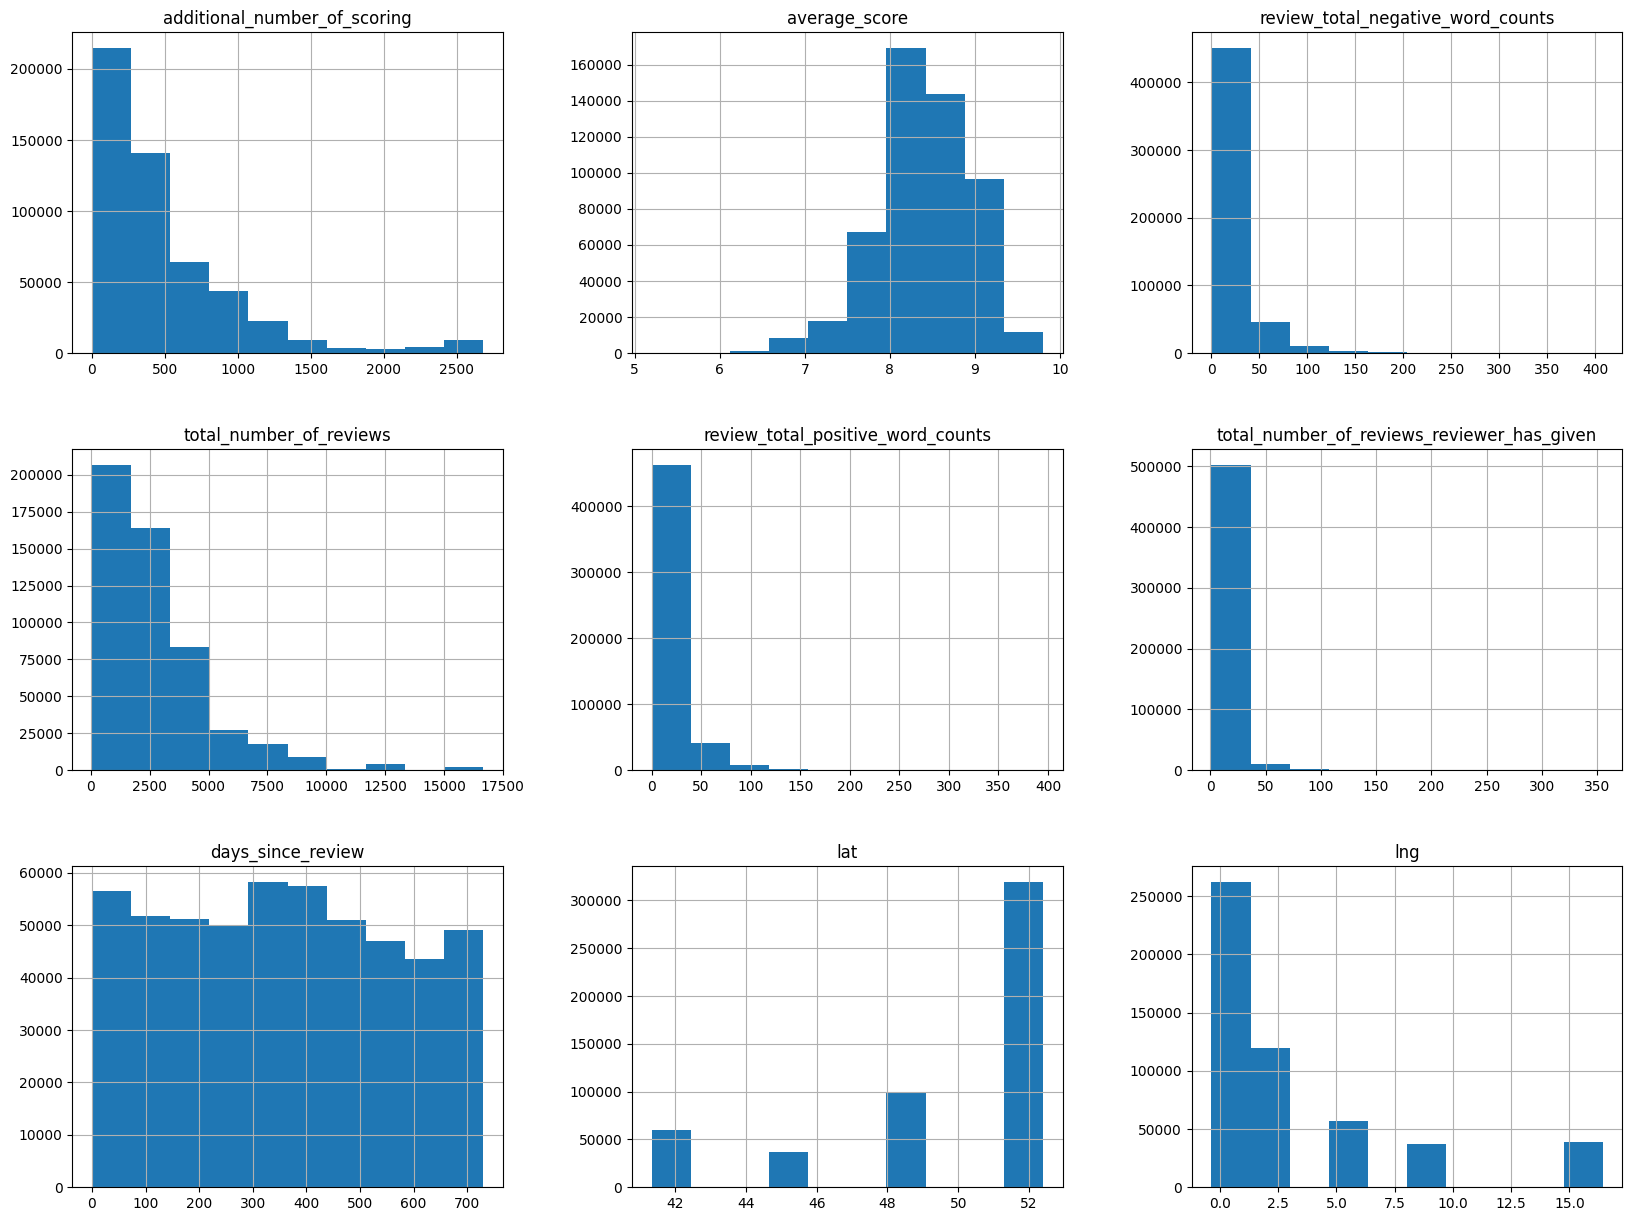

In [336]:
hotels[num_cols].hist(figsize=(20, 15))

We'll aply logarithmic transformation to the right-skewed features: additional_number_of_scoring, review_total_negative_word_counts, total_number_of_reviews, review_total_positive_word_counts, total_number_of_reviews_reviewer_has_given.

array([[<Axes: title={'center': 'additional_number_of_scoring_log'}>,
        <Axes: title={'center': 'review_total_negative_word_counts_log'}>],
       [<Axes: title={'center': 'total_number_of_reviews_log'}>,
        <Axes: title={'center': 'review_total_positive_word_counts_log'}>],
       [<Axes: title={'center': 'total_number_of_reviews_reviewer_has_given_log'}>,
        <Axes: >]], dtype=object)

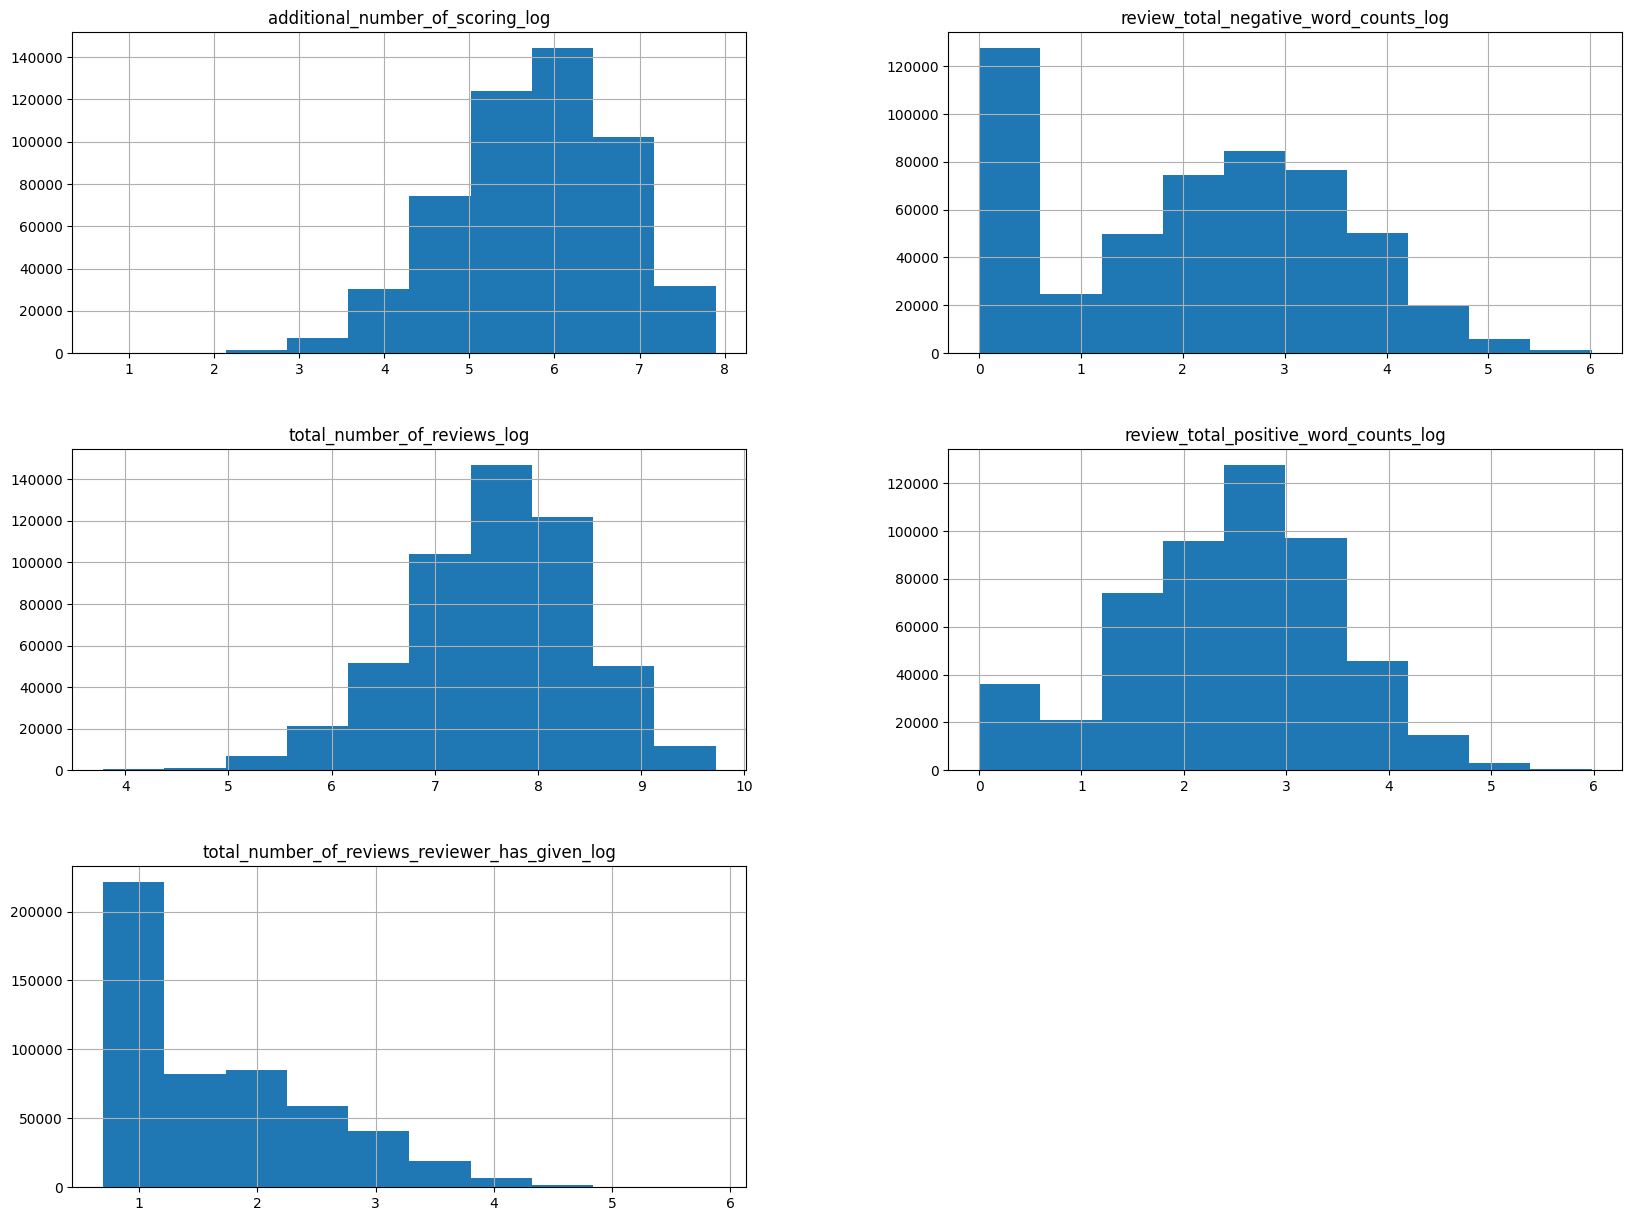

In [337]:
hotels_transformed = hotels.copy()

# List of features to apply log transformation
features_to_transform = [
    'additional_number_of_scoring', 
    'review_total_negative_word_counts', 
    'total_number_of_reviews', 
    'review_total_positive_word_counts', 
    'total_number_of_reviews_reviewer_has_given'
]

# Applying log transformation
for feature in features_to_transform:
    hotels_transformed[feature + '_log'] = np.log(hotels[feature] + 1)
    
log_cols = [
    'additional_number_of_scoring_log', 
    'review_total_negative_word_counts_log',
    'total_number_of_reviews_log',
    'review_total_positive_word_counts_log',
    'total_number_of_reviews_reviewer_has_given_log'
]

hotels_transformed[log_cols].hist(figsize=(20, 15))


Review_total_negative_word_counts and total_number_of_reviews_reviewer_has_given still has significant scewness to the right, but log transformation has mostly worked. We'll drop the original pre-log features. 

In [338]:
columns_to_drop = [
    'additional_number_of_scoring', 
    'review_total_negative_word_counts', 
    'total_number_of_reviews', 
    'review_total_positive_word_counts', 
    'total_number_of_reviews_reviewer_has_given'
]

hotels_transformed.drop(columns = columns_to_drop, inplace=True)
hotels_transformed.columns.to_list()

['average_score',
 'reviewer_nationality_0',
 'reviewer_nationality_1',
 'reviewer_nationality_2',
 'reviewer_nationality_3',
 'reviewer_nationality_4',
 'reviewer_nationality_5',
 'reviewer_nationality_6',
 'reviewer_nationality_7',
 'reviewer_score',
 'days_since_review',
 'lat',
 'lng',
 'dataset',
 'city_Amsterdam',
 'city_Barcelona',
 'city_London',
 'city_Milan',
 'city_Paris',
 'city_Vienna',
 'is_downtown',
 'is_same_nationality',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'season_winter',
 'season_spring',
 'season_summer',
 'season_autumn',
 'is_weekend',
 'has_common_good_words',
 'has_common_bad_words',
 'is_Leisure_trip',
 'is_Submitted_from_a_mobile_device',
 'is_Couple',
 'is_Stayed_1_night',
 'is_Stayed_2_nights',
 'is_Solo_traveler',
 'is_Stayed_3_nights',
 'is_Business_trip',
 'is_Group',
 'is_Family_with_young_children',
 'is_Stayed_4_nights',
 'is_Double_Room',
 

We will standardize the numerical features.

array([[<Axes: title={'center': 'additional_number_of_scoring_log'}>,
        <Axes: title={'center': 'average_score'}>,
        <Axes: title={'center': 'review_total_negative_word_counts_log'}>],
       [<Axes: title={'center': 'total_number_of_reviews_log'}>,
        <Axes: title={'center': 'review_total_positive_word_counts_log'}>,
        <Axes: title={'center': 'total_number_of_reviews_reviewer_has_given_log'}>],
       [<Axes: title={'center': 'days_since_review'}>,
        <Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lng'}>]],
      dtype=object)

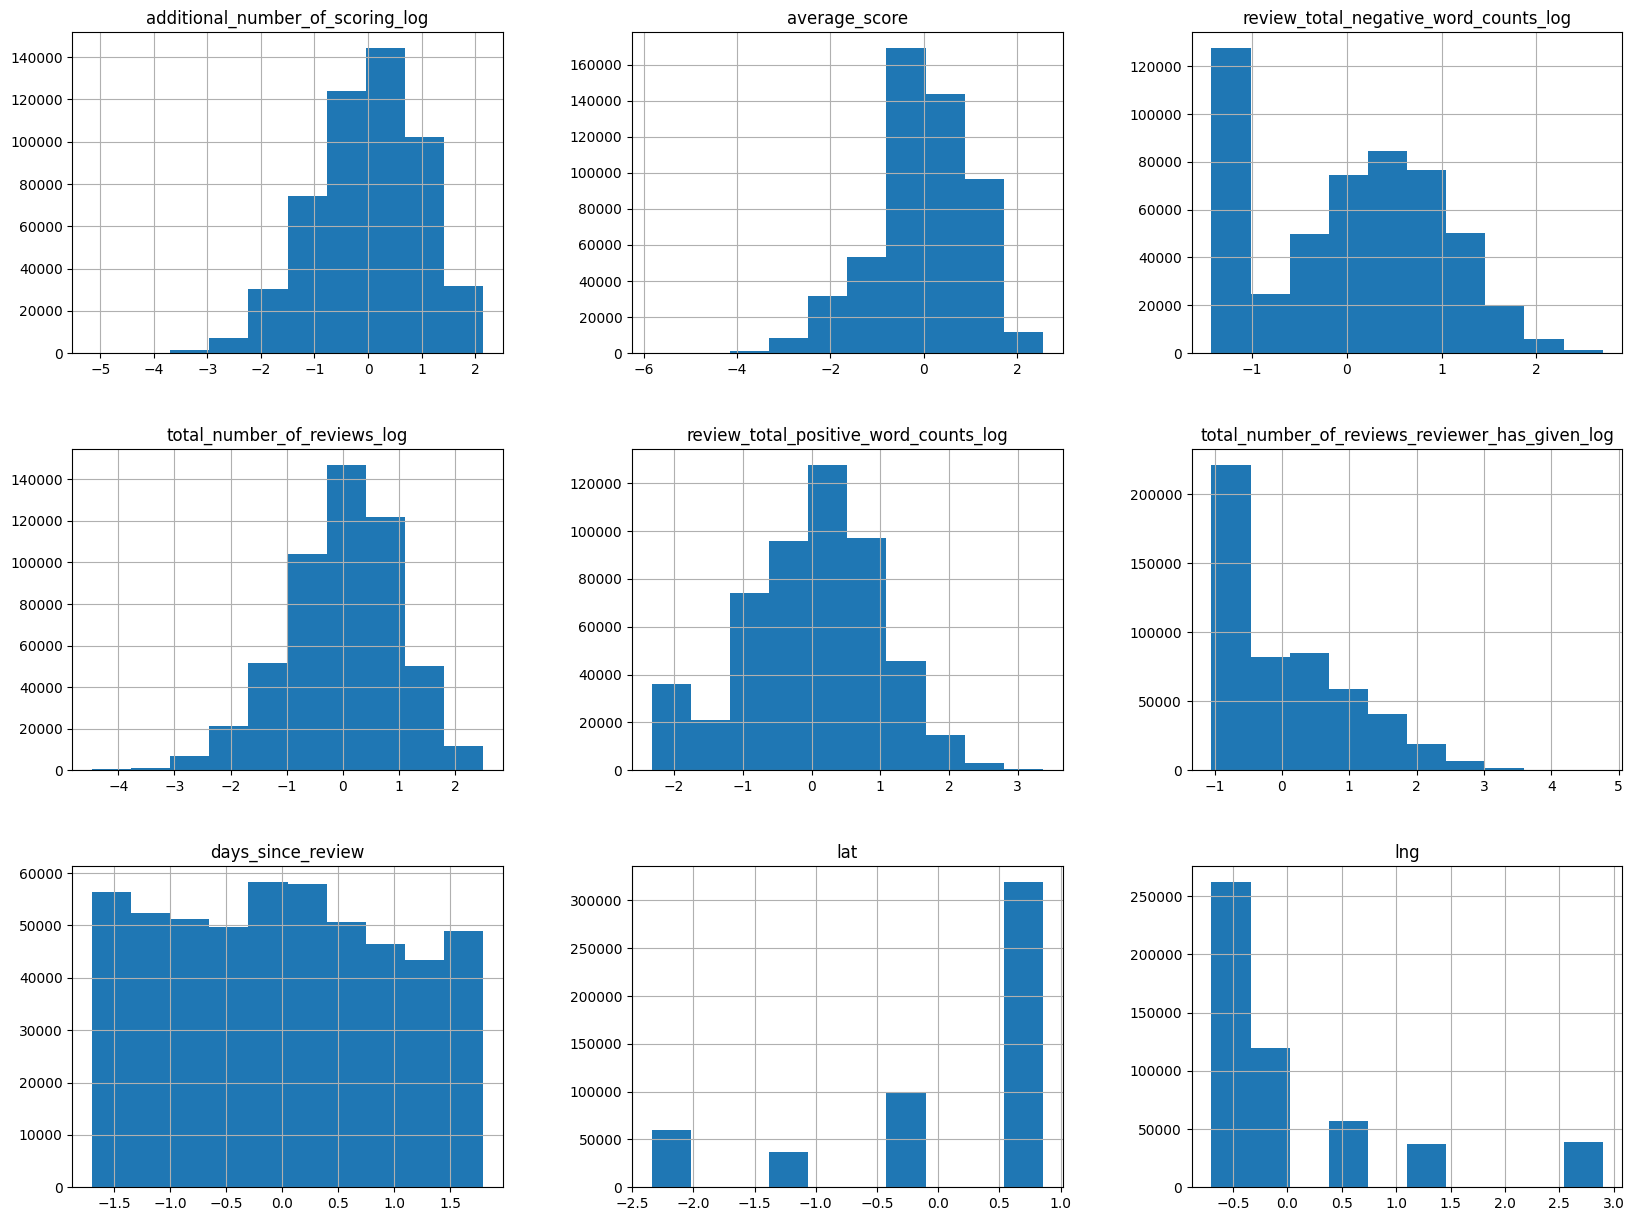

In [339]:
num_cols = [
    'additional_number_of_scoring_log', 
    'average_score', 
    'review_total_negative_word_counts_log',
    'total_number_of_reviews_log',
    'review_total_positive_word_counts_log',
    'total_number_of_reviews_reviewer_has_given_log',
    'days_since_review',
    'lat',
    'lng']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
hotels_transformed[num_cols] = scaler.fit_transform(hotels_transformed[num_cols])

hotels_transformed[num_cols].hist(figsize=(20, 15))

We'll now us Pearson's test to check if there is any multicollinearity among these numerical features. 

<Axes: title={'center': 'Correlation heatmap'}>

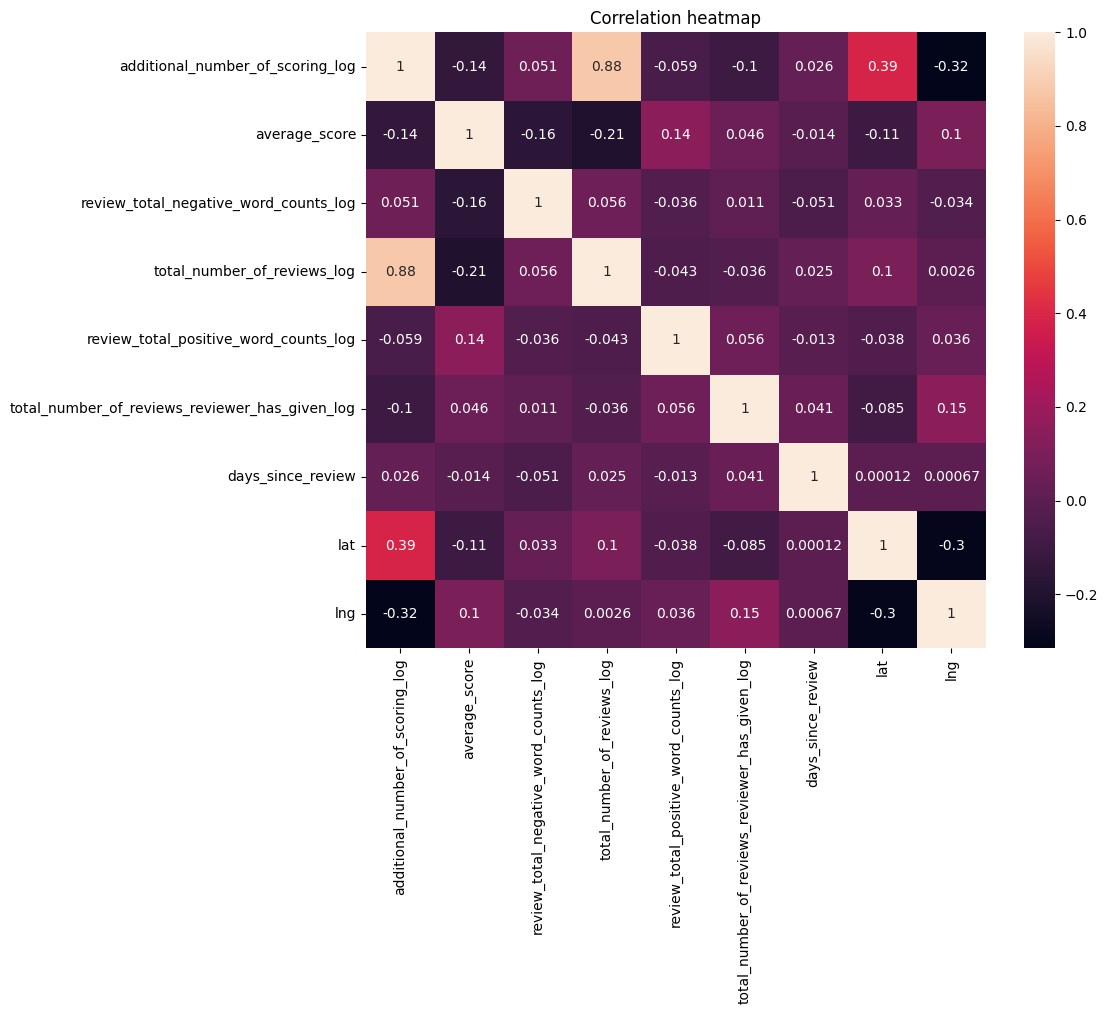

In [340]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 8))
ax.set_title('Correlation heatmap')
sns.heatmap(hotels_transformed[num_cols].corr(method='pearson'), annot=True, ax=ax)

We'll drop the 'total_number_of_reviews' feature since it has high correlation with "additional_nuber_of_scoring_log".

In [341]:
hotels_transforemd = hotels_transformed.drop(columns = 'total_number_of_reviews_log')

We'll now look at the correlation between categorical features (which are too many to be visible on a heatmap, so we'll have to do a chart).

In [342]:
# Target feature
target = 'reviewer_score'

# Dataset splitting feature
dataset_feature = 'dataset'

# Identifying all columns in hotels_transformed
all_columns = hotels_transformed.columns.tolist()

# Excluding numerical columns, target feature, and dataset splitting feature
cat_cols = [col for col in all_columns if col not in num_cols and col != target and col != dataset_feature]


In [343]:
from scipy.stats import spearmanr

corr_matrix = hotels_transformed[cat_cols].corr(method='spearman')

# Flattening the correlation matrix and sorting by absolute correlation value in descending order
corr_pairs = corr_matrix.unstack()
sorted_corr_pairs = corr_pairs.abs().sort_values(kind="quicksort", ascending=False)

# Displaying the top 10 most correlated pairs (excluding self-correlations)
sorted_corr_pairs = sorted_corr_pairs[sorted_corr_pairs != 1.0]


In [344]:
print(sorted_corr_pairs.head(30))

is_Business_trip     is_Leisure_trip        0.904047
is_Leisure_trip      is_Business_trip       0.904047
city_London          is_same_nationality    0.651570
is_same_nationality  city_London            0.651570
month_10             season_autumn          0.546915
season_autumn        month_10               0.546915
season_winter        month_1                0.541389
month_1              season_winter          0.541389
season_spring        month_5                0.540824
month_5              season_spring          0.540824
month_9              season_autumn          0.537072
season_autumn        month_9                0.537072
month_8              season_summer          0.533157
season_summer        month_8                0.533157
is_Solo_traveler     is_Business_trip       0.528530
is_Business_trip     is_Solo_traveler       0.528530
season_summer        month_7                0.525292
month_7              season_summer          0.525292
season_winter        month_12               0.

The 'is_Business_trip' and 'is_Leisure_trip' show a high correlation of 0.9. We'll remove the 'is_Business_trip' feature and procede with the algorithm. 

In [345]:
hotels_transformed = hotels_transformed.drop(columns='is_Business_trip')

We'll now split the algorithm back into train and test data, remove the target feature and the 'dataset' column. 

### Running the algorithm:

Splitting the datasets back into train and test data. 

In [346]:
hotels_train = hotels_transformed[hotels_transformed['dataset'] == 'train']
hotels_test = hotels_transformed[hotels_transformed['dataset'] == 'test']

#Removing the 'dataset' feature
train_data = hotels_train.drop(columns=['dataset'])
test_data = hotels_test.drop(columns=['dataset'])
test_data['reviewer_score'] = 0

# Separating features and target variable in training data
X = train_data.drop(columns=['reviewer_score'])
y = train_data.reviewer_score.values 

In [347]:
hotels_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128935 entries, 386496 to 515430
Data columns (total 70 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   average_score                                   128935 non-null  float64
 1   reviewer_nationality_0                          128935 non-null  int64  
 2   reviewer_nationality_1                          128935 non-null  int64  
 3   reviewer_nationality_2                          128935 non-null  int64  
 4   reviewer_nationality_3                          128935 non-null  int64  
 5   reviewer_nationality_4                          128935 non-null  int64  
 6   reviewer_nationality_5                          128935 non-null  int64  
 7   reviewer_nationality_6                          128935 non-null  int64  
 8   reviewer_nationality_7                          128935 non-null  int64  
 9   reviewer_score            

In [348]:
# Importing the data-splitting instrument
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [349]:
# Checking the results of the splitting
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 69), (386496, 69), (386496, 68), (309196, 68), (77300, 68))

In [373]:
    regr = RandomForestRegressor(n_estimators=100)  
      
    # Training the model on the test data
    regr.fit(X_train, y_train)  
      
    # Using the trained model to predict hotel ratings in test data. 
    # Saving the predicted values in y_pred  
    y_pred = regr.predict(X_test) 

In [374]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13210183501388206


Let's run statistical tests to see which features were most important for the ml algorithm.

<Axes: >

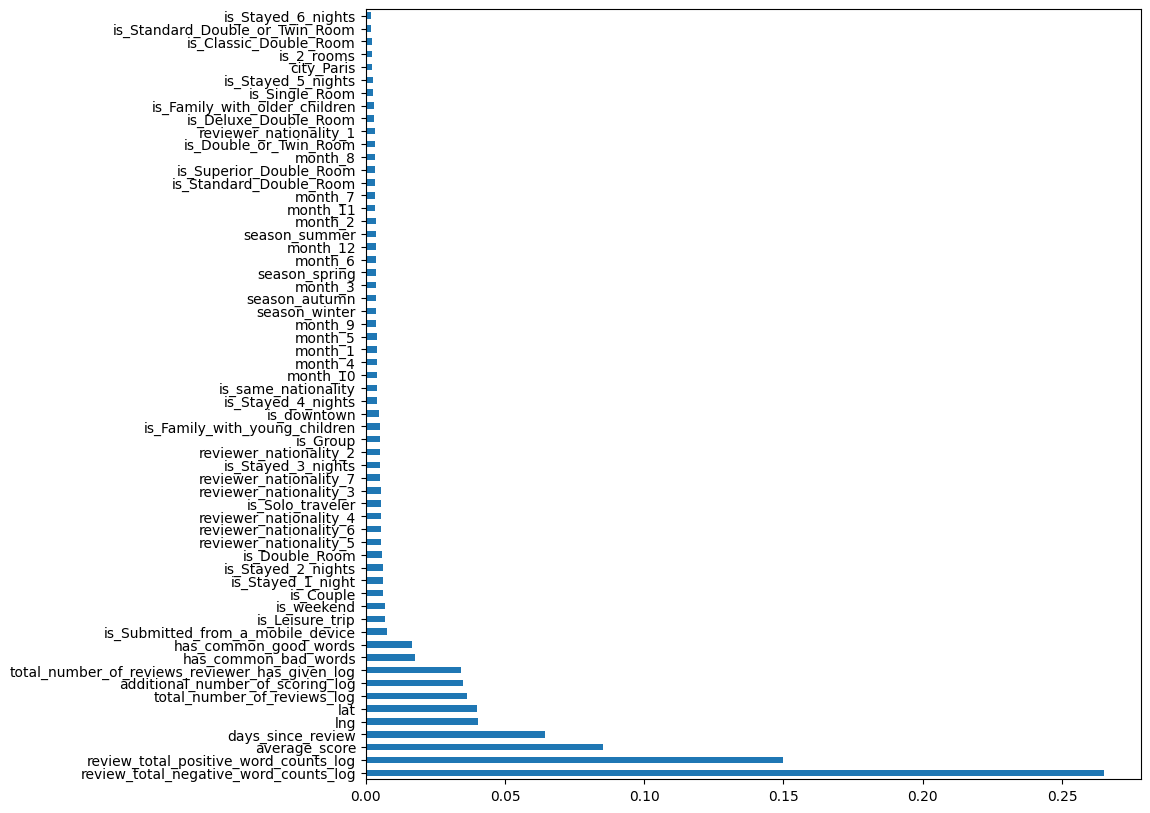

In [352]:
# Visualizing the most important features
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(60).plot(kind='barh')

We can see that the most important features for the model are all the numerical ones. Let's vizualise the importance of only categorical features to see which we should drop. 

In [353]:
new_cat_cols = [col for col in cat_cols if col != 'is_Business_trip']
print(new_cat_cols)

['reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5', 'reviewer_nationality_6', 'reviewer_nationality_7', 'city_Amsterdam', 'city_Barcelona', 'city_London', 'city_Milan', 'city_Paris', 'city_Vienna', 'is_downtown', 'is_same_nationality', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'season_winter', 'season_spring', 'season_summer', 'season_autumn', 'is_weekend', 'has_common_good_words', 'has_common_bad_words', 'is_Leisure_trip', 'is_Submitted_from_a_mobile_device', 'is_Couple', 'is_Stayed_1_night', 'is_Stayed_2_nights', 'is_Solo_traveler', 'is_Stayed_3_nights', 'is_Group', 'is_Family_with_young_children', 'is_Stayed_4_nights', 'is_Double_Room', 'is_Standard_Double_Room', 'is_Superior_Double_Room', 'is_Family_with_older_children', 'is_Deluxe_Double_Room', 'is_Double_or_Twin_Room', 'is_Stayed_5_nig

We'll run the Chi-square test for the categorical features.

<Axes: >

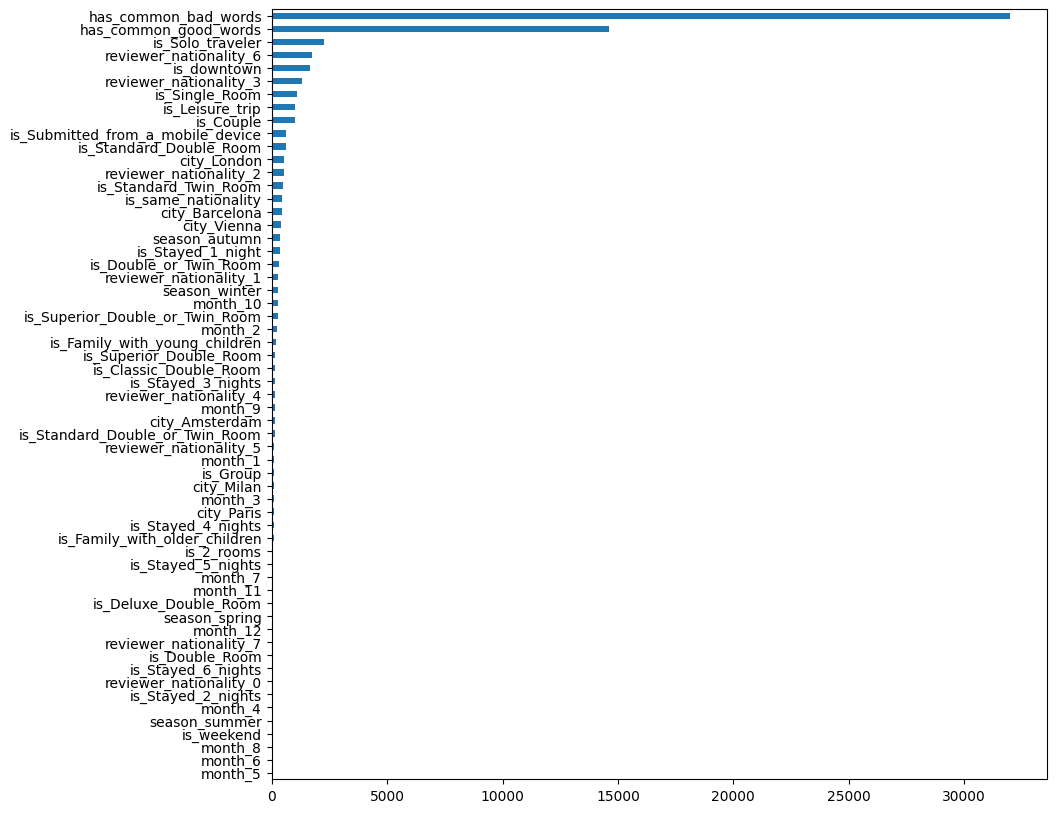

In [354]:

y=y.astype('int')
imp_cat = pd.Series(chi2(X[new_cat_cols], y)[0], index=new_cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In the following code I attampted to reduce the MAPE value by only keeping the features with importance value over 50 (I've also tried 100 and 200), but that only increased the MAPE value, so I'm hashing all the code below and submitting the original version. 

In [355]:
#Let's only keep the features with importance value over 50.

#imp_cat = pd.DataFrame(imp_cat)
#imp_cat = imp_cat.sort_values(0, ascending=False)
#imp_cat = imp_cat.reset_index()

In [356]:
#imp_cat_cols = imp_cat[imp_cat[0]>50]
#imp_cat_cols

In [357]:
#imp_cat_cols = imp_cat_cols['index'].tolist()
#print(imp_cat_cols)


In [358]:
#selected_cols = num_cols + imp_cat_cols + ['dataset'] + ['reviewer_score']
#final_hotels = hotels_transformed[selected_cols]

#final_hotels_train = final_hotels[final_hotels['dataset'] == 'train']
#final_hotels_test = final_hotels[final_hotels['dataset'] == 'test']

# Removing the 'dataset' feature

#final_train_data = final_hotels_train.drop(columns=['dataset'])
#final_test_data = final_hotels_test.drop(columns=['dataset'])
#final_test_data['reviewer_score'] = 0

# Separating features and target variable in training data

#X = final_train_data.drop(columns=['reviewer_score'])
#y = final_train_data.reviewer_score.values 

In [359]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)


In [360]:
# Checking the results of the splitting

#final_test_data.shape, final_train_data.shape, X.shape, X_train.shape, X_test.shape

In [361]:
#regr = RandomForestRegressor(n_estimators=100)  
      
# Training the model on the test data

#regr.fit(X_train, y_train)  
      
# Using the trained model to predict hotel ratings on the test data  
# Saving the predicted values into y_pred

#y_pred = regr.predict(X_test) 

In [362]:
#print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))
# MAPE: 0.13277998795074528

Submitting the results

In [375]:
sample_submission = pd.read_csv(r'/kaggle/input/sf-booking/submission.csv')
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [ ]:
test_data = test_data.drop(columns='reviewer_score')

In [378]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128935 entries, 386496 to 515430
Data columns (total 68 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   average_score                                   128935 non-null  float64
 1   reviewer_nationality_0                          128935 non-null  int64  
 2   reviewer_nationality_1                          128935 non-null  int64  
 3   reviewer_nationality_2                          128935 non-null  int64  
 4   reviewer_nationality_3                          128935 non-null  int64  
 5   reviewer_nationality_4                          128935 non-null  int64  
 6   reviewer_nationality_5                          128935 non-null  int64  
 7   reviewer_nationality_6                          128935 non-null  int64  
 8   reviewer_nationality_7                          128935 non-null  int64  
 9   days_since_review         

In [379]:
predict_submission = regr.predict(test_data)

In [380]:
predict_submission

array([8.879, 7.379, 8.253, ..., 8.298, 9.587, 7.037])

In [381]:
list(sample_submission)

['reviewer_score', 'id']

In [383]:
sample_submission['reviewer_score'] = predict_submission

In [384]:
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.879,488440
1,7.379,274649
2,8.253,374688
3,9.702,404352
4,9.708,451596
5,8.652,302161
6,8.702,317079
7,8.272,13963
8,8.576,159785
9,7.821,195089
